In [2]:
import os
import networkx as nx
import matplotlib.pyplot as plt
import numpy as np
import random
import datetime
import igraph as ig
import pandas as pd
import tensorflow as tf
import time
import os
import keras_tuner
import json
import seaborn as sns
from tensorflow import keras
from methods import *

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

### Automatic hyperparameter tuning

In [7]:
def build_hypermodel(hp):
    #for n=20 models
    n = 20

    count =     hp.Int("layer_count", min_value = 4, max_value = 12, step = 1)
    eq_depth =  hp.Int("channels", min_value = 200, max_value = 1000, step = 100) 
    lr =        hp.Float("lr", min_value = 1e-5, max_value = 1.5e-3, sampling = "log")
    alpha =     hp.Float("alpha", min_value = 0, max_value = 0.4)
    b1 =        hp.Float("beta_1", min_value = 0.8, max_value = 0.98, sampling = "log")
    b2 =        hp.Float("beta_2", min_value = 0.95, max_value = 0.9995, sampling = "log")

    layers = list()
    layers.append(MyEqLayer(2, eq_depth))                   #input layer
    layers.append(tf.keras.layers.LeakyReLU(alpha))
    for i in range(count - 2):
        layers.append(MyEqLayer(eq_depth, eq_depth))
        layers.append(tf.keras.layers.LeakyReLU(alpha))
    layers.append(MyEqLayer(eq_depth, 1))                   #output layer
    layers.append(tf.keras.layers.Activation('sigmoid'))
    layers.append(tf.keras.layers.Reshape((n, n)))
    model = keras.Sequential(layers)

    optimizer = keras.optimizers.Adam(learning_rate = lr, beta_1 = b1, beta_2 = b2, epsilon = 1e-7)
    model.compile(
        optimizer = optimizer,
        loss = keras.losses.BinaryCrossentropy(),
        metrics = ["accuracy"]
    )
        
    return model

tuner = keras_tuner.RandomSearch(
    hypermodel = build_hypermodel,
    objective = "val_accuracy",
    max_trials = 500,
    executions_per_trial = 3,
    overwrite = False,
    directory = "checkpoints/randomsearch2",
    project_name = "EQ-model"
)

tuner.search_space_summary()

Search space summary
Default search space size: 6
layer_count (Int)
{'default': None, 'conditions': [], 'min_value': 4, 'max_value': 12, 'step': 1, 'sampling': 'linear'}
channels (Int)
{'default': None, 'conditions': [], 'min_value': 200, 'max_value': 1000, 'step': 100, 'sampling': 'linear'}
lr (Float)
{'default': 1e-05, 'conditions': [], 'min_value': 1e-05, 'max_value': 0.0015, 'step': None, 'sampling': 'log'}
alpha (Float)
{'default': 0.0, 'conditions': [], 'min_value': 0.0, 'max_value': 0.4, 'step': None, 'sampling': 'linear'}
beta_1 (Float)
{'default': 0.8, 'conditions': [], 'min_value': 0.8, 'max_value': 0.98, 'step': None, 'sampling': 'log'}
beta_2 (Float)
{'default': 0.95, 'conditions': [], 'min_value': 0.95, 'max_value': 0.9995, 'step': None, 'sampling': 'log'}


In [8]:
ngraphs =       4096
vals =          1000
nodes =         20
edges =         nodes*3
graph_type =    "SF"
sem_type =      "gauss"
k =             1
batch_size =    32
epochs =        25
params = (ngraphs, vals, nodes, edges, graph_type, sem_type, k)
my_DAG_sequence = DAG_sequence(params, batch_size)
early_stopping = tf.keras.callbacks.EarlyStopping(monitor = 'loss', patience = 3)

tuner.search(my_DAG_sequence, epochs = epochs, validation_data = my_DAG_sequence, callbacks = [early_stopping])

Trial 215 Complete [00h 06m 25s]
val_accuracy: 0.18989664812882742

Best val_accuracy So Far: 0.3544433613618215
Total elapsed time: 3d 21h 44m 09s

Search: Running Trial #216

Value             |Best Value So Far |Hyperparameter
9                 |6                 |layer_count
700               |1000              |channels
6.572e-05         |0.00042674        |lr
0.071469          |0.060208          |alpha
0.82723           |0.82735           |beta_1
0.99737           |0.95018           |beta_2

Epoch 1/25
128/128 [==============================] - 44s 335ms/step - loss: 0.3005 - accuracy: 0.2498 - val_loss: 0.2366 - val_accuracy: 0.2473
Epoch 2/25
128/128 [==============================] - 36s 278ms/step - loss: 0.2190 - accuracy: 0.2487 - val_loss: 0.1825 - val_accuracy: 0.2572
Epoch 3/25
128/128 [==============================] - 36s 279ms/step - loss: 0.1676 - accuracy: 0.2909 - val_loss: 0.1569 - val_accuracy: 0.2981
Epoch 4/25
128/128 [==============================] - 36s 282m

KeyboardInterrupt: 

### Hyperparameter tuning result analysis

In [36]:
path = "G:/Asiakirjat/Gradu/Code/checkpoints/randomsearch/EQ-model/trial_0"
scores = list()
for i in range(100):
    a = str(i)
    if len(a) == 1:
        a = "0" + a
    fpath = path + a + "/trial.json"
    with open(fpath) as file:
        data = json.load(file)
        score = data["score"]
        scores.append(score)
path = "G:/Asiakirjat/Gradu/Code/checkpoints/randomsearch2/EQ-model/trial_"
for i in range(215):
    a = str(i)
    if len(a) == 1:
        a = "00" + a
    elif len(a) == 2:
        a = "0" + a
    fpath = path + a + "/trial.json"
    with open(fpath) as file:
        data = json.load(file)
        score = data["score"]
        scores.append(score)

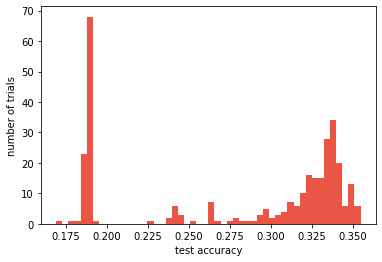

In [46]:
plt.hist(scores, bins = 50)
plt.xlabel("test accuracy")
plt.ylabel("number of trials")
plt.savefig("plot", dpi = 500, transparent = "False")

In [51]:
fpath = "/checkpoints/randomsearch2/EQ-model/trial_011/trial.json"
with open(fpath) as file:
    data = json.load(file)
hp = data["hyperparameters"]["values"]
for key, value in zip(hp.keys(), hp.values()):
    print(key, value)

layer_count 6
channels 1000
lr 0.00042673764158508763
alpha 0.06020792154330756
beta_1 0.8273531944522186
beta_2 0.9501810422513404


### Train model

In [57]:
def eval_notears(true, predicted):
    accs_out = count_accuracy(true, predicted, "list")
    fdr = accs_out[2]
    prec = accs_out[0]
    recall = accs_out[1]
    F1 = 2*prec*recall/(prec+recall)
    shd = accs_out[5]
    return np.array([fdr, prec, recall, F1, shd])

def notears_test(n, d, s0, graph_type, sem_type, l1, iters):
    start = time.time()
    accs = np.zeros(5)
    for i in range(iters):
        B_true = simulate_dag(d, s0, graph_type)
        W_true = simulate_parameter(B_true)
        X = simulate_linear_sem(W_true, n, sem_type)
        W_est = notears_linear(X, lambda1=l1, loss_type='l2')
        accs += eval_notears(B_true, W_est != 0)
        print("step %i/%i" % (i, iters) , end="\r", flush=True)
    runtime = time.time() - start
    output = list()
    print("FDR\tprec\trecall\tF1\tSHD")
    for val, name in zip(accs/iters, "FDR prec recal F1 SHD".split(" ")):
        output.append(name + "\t" + str(val))
        print(str(format(val, ".3f")) + "\t", end = '')
    timing = "\nruntime per graph " + str(runtime/iters)
    output.append(timing)

    for param in [n, d, s0, graph_type, sem_type, l1, iters]:
        output.append(param)
    np.savetxt("notears" + str(d) + ".txt", np.array(output), fmt='%s')
    print(timing)

In [61]:
def train_model(params, batch_size, epochs, eq_depth, count, optimizer, alpha, sequence, online = True, ens = None):
    #trains a model for selected configuration
    #then saves to file with loss history plot and configuration information
    
    assert epochs > 2
    ngraphs, vals, nodes, edges, graph_type, sem_type, k = params
    now = datetime.datetime.now().strftime("%m%d_%H%M")
    if online:
        path = "checkpoints/" + str(nodes) + "_" + now
    else:
        path = "checkpoints/offline_" + str(nodes) + "_" + now
    os.makedirs(path)
    history = keras.callbacks.History()
    checkpoint = tf.keras.callbacks.ModelCheckpoint(
        filepath = path, 
        verbose = 0,
        save_weights_only = False,
        save_freq = "epoch")

    layers = list()
    layers.append(MyEqLayer(2, eq_depth))                   #input layer
    layers.append(tf.keras.layers.LeakyReLU(alpha = alpha))
    for i in range(count - 2):
        layers.append(MyEqLayer(eq_depth, eq_depth))
        layers.append(tf.keras.layers.LeakyReLU(alpha = alpha))
    layers.append(MyEqLayer(eq_depth, 1))                   #output layer
    layers.append(tf.keras.layers.Activation('sigmoid'))
    layers.append(tf.keras.layers.Reshape((params[2],params[2])))
    model = keras.Sequential(layers)

    model.compile(
        optimizer = optimizer,
        loss = keras.losses.BinaryCrossentropy()
    )

    start = time.time()

    if online:
        model.fit(
            sequence,
            batch_size = batch_size,
            epochs = epochs,
            callbacks = [history, checkpoint]
        )
    else:
        if ens == None:
            x, y = gen_train_data(800, vals, nodes, edges, graph_type, sem_type, k)
        elif ens == "rho":
            x, y = gen_train_data_rho_ensemble(800, vals, nodes, edges, graph_type, sem_type, k)
        elif ens == "k":
            x, y = gen_train_data_k_ensemble(800, vals, nodes, edges, graph_type, sem_type, k)
        model.fit(
            x,
            y,
            batch_size = batch_size,
            epochs = epochs,
            callbacks = [history, checkpoint]
        )

    training_time = time.time() - start

    #store model parameters in file
    c = optimizer.get_config()
    output = list()
    for p, name in zip(params, "ngraphs vals nodes edges graph_type sem_type k".split(" ")):
        output.append(str(name) + ": " + str(p))
    for p, name in zip((batch_size, epochs, eq_depth, count), "batch_size epochs eq_depth count".split(" ")):
        output.append(str(name) + ": " + str(p))
    for name, p in zip(c.keys(), c.values()):
        output.append(str(name) + ": " + str(p))
    output.append("training time: " + str(int(training_time)))
    if online:
        output.append("data generator: " + str(sequence))
    else:
        output.append("offline ensemble: " + str(ens))
    output.append("")

    densities = [1,2,1,1,1]
    ks =        [1,1,2,4,8]

    output.append("d, k, FDR, prec, recall, SHD")
    for density, k in zip(densities, ks):
        results = np.zeros(6)
        for _ in range(1024//batch_size):
            test_x, test_y = gen_train_data(batch_size, vals, nodes, nodes*density, graph_type, sem_type, k)
            results += np.array(eval_model(model, test_x, test_y))
        results /= 1024//batch_size
        results_str = [format(val, ".3g") for val in [results[0]*100, results[1]*100, results[2]*100, results[4]]]
        output.append(str(density) + " " + str(k) + " " + " &\t".join(results_str))

    pd.Series(output).to_csv(path + "/config.txt", index = False, header = False)

    #graph loss history by epoch and store in file
    losses = history.history["loss"]
    np.savetxt(path + "/losses.csv", losses)
    plt.plot(losses)
    plt.xlabel("epoch")
    plt.ylabel("loss")
    plt.savefig(path + "/loss.svg")
    plt.show()

    return model

Epoch 1/256
25/25 [==============================] - 20s 747ms/step - loss: 0.3516
Epoch 2/256
25/25 [==============================] - 18s 732ms/step - loss: 0.2080
Epoch 3/256
25/25 [==============================] - 19s 738ms/step - loss: 0.1487
Epoch 4/256
25/25 [==============================] - 18s 735ms/step - loss: 0.1272
Epoch 5/256
25/25 [==============================] - 18s 729ms/step - loss: 0.1151
Epoch 6/256
25/25 [==============================] - 19s 746ms/step - loss: 0.1091
Epoch 7/256
25/25 [==============================] - 19s 761ms/step - loss: 0.1037
Epoch 8/256
25/25 [==============================] - 19s 742ms/step - loss: 0.1012
Epoch 9/256
25/25 [==============================] - 17s 686ms/step - loss: 0.1005
Epoch 10/256
25/25 [==============================] - 18s 723ms/step - loss: 0.0978
Epoch 11/256
25/25 [==============================] - 17s 692ms/step - loss: 0.0972
Epoch 12/256
25/25 [==============================] - 17s 690ms/step - loss: 0.0955
E

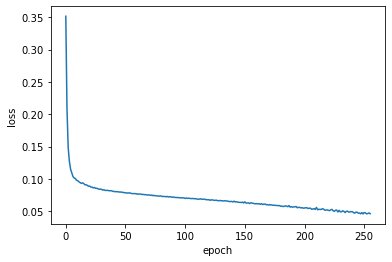

In [55]:
ngraphs =       800
vals =          1000
nodes =         50
density =       1
graph_type =    "SF"
sem_type =      "gauss"
k =             1
batch_size =    32
epochs =        256
eq_depth =      1000
count =         6
alpha =         0.06020792154330756
lr =            0.00042673764158508763
b1 =            0.8273531944522186
b2 =            0.9501810422513404

params = (ngraphs, vals, nodes, nodes*density, graph_type, sem_type, k)
sequence = DAG_sequence(params, batch_size)
optimizer = keras.optimizers.Adam(learning_rate = lr, beta_1 = b1, beta_2 = b2, epsilon = 1e-7)

keras.backend.clear_session()
model = train_model(params, batch_size, epochs, eq_depth, count, optimizer, alpha, sequence)

### Test loaded model

In [56]:
vals =          1000
n =             50
graph_type =    "SF"
sem_type =      "gauss"
k =             1
density =       1
batch_size =    32

path = '/checkpoints/offline_rho_50_50ep(equiv)'
#for n in [10,20,50]:
for density in [1,2,4,8]:
    file = path #+ str(n)
    model = keras.models.load_model(file)
    
    if n == 100:
        batch_size = 8
    results = np.zeros(6)
    for _ in range(1024//batch_size):
        test_x, test_y = gen_train_data(batch_size, vals, n, n*density, graph_type, sem_type, k)
        results += np.array(eval_model(model, test_x, test_y))
    results /= 1024//batch_size

    metrics = [results[1]*100, results[2]*100, results[4]]
    out = str(density)
    for val in metrics:
        out += "& " + format(val, ".3f")
    print(out)

1& 94.921& 97.489& 4.248
2& 70.709& 81.935& 47.836
4& 66.392& 70.632& 124.272
8& 60.254& 74.706& 223.630


### Custom BA algorithm

485.0    106
197.0    104
390.0     98
294.0     92
99.0      56
579.0     44
dtype: int64

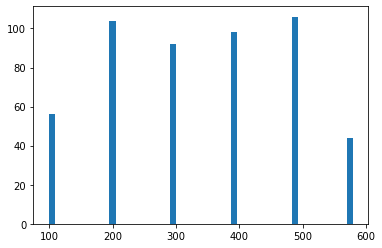

In [40]:
ngraphs =       4096
vals =          1000
nodes =         100
density =       1
graph_type =    "SF"
sem_type =      "gauss"
k =             1
batch_size =    500

edge_counts = list()
test_x, test_y = gen_train_data_rho_ensemble(batch_size, vals, nodes, nodes*4, graph_type, sem_type, k)
for i in range(batch_size):
    edge_counts.append(test_y[i].sum())
plt.hist(edge_counts, bins = 50)
pd.Series(edge_counts).value_counts()

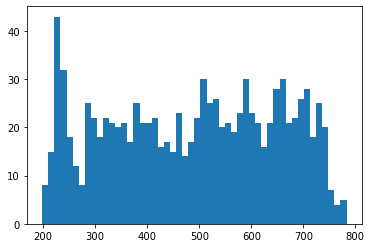

In [3]:
edge_counts = list()
for _ in range(1024):
    G = randomised_barabasi_generator(100)
    edge_counts.append(sum(sum(G)))
    if not ig.Graph.Adjacency(G.tolist()).is_dag():
        print(False)
plt.hist(edge_counts, bins = 50)
plt.show()

### Confidence testing

In [2]:
file = '/checkpoints/rho_50'
model = keras.models.load_model(file)

density: 1
	correlations
	prec 	 0.5877218991391604
	recall 	 0.6348179732645473
	SHD 	 0.7148448862754053
	averages
	prec 	 0.9598812181122449
	recall 	 0.9892280948310703
	SHD 	 2.4814453125
density: 2
	correlations
	prec 	 0.3353280462180104
	recall 	 0.7127639618126821
	SHD 	 0.6913455138745348
	averages
	prec 	 0.7052996134020617
	recall 	 0.8716428592014419
	SHD 	 38.7763671875
density: 4
	correlations
	prec 	 0.04846207268544614
	recall 	 0.7756457457815004
	SHD 	 0.7456357144854223
	averages
	prec 	 0.6693462171052631
	recall 	 0.7628982094615862
	SHD 	 103.0478515625
density: 8
	correlations
	prec 	 0.48714093176264384
	recall 	 0.32057223090043635
	SHD 	 0.550201091742449
	averages
	prec 	 0.5952470381181318
	recall 	 0.8195386757438959
	SHD 	 192.525390625


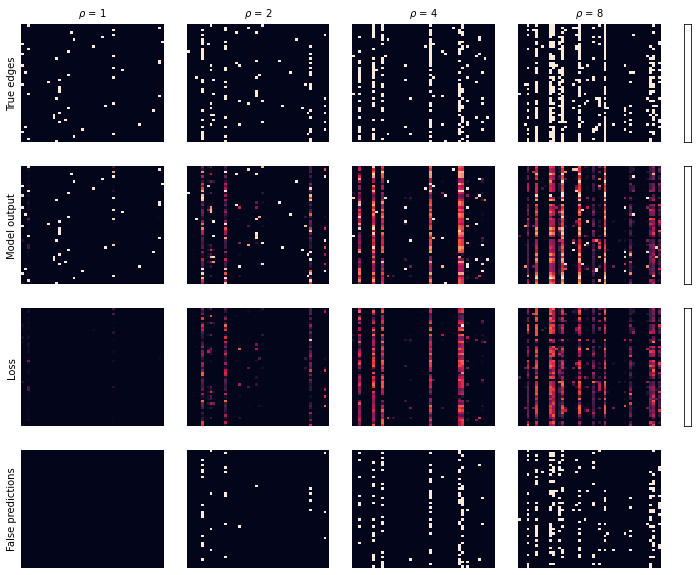

In [3]:
vals =          1000
graph_type =    "SF"
sem_type =      "gauss"
k =             1
batch_size =    32
nodes =         50
density =       1
num_samples =   1024

def eval_model_loss(model, x, y):
    out = model(x).numpy()
    out_bin = output_acyclic(np.copy(out))
    bce = tf.keras.losses.BinaryCrossentropy(from_logits = False)
    prec_l, recall_l, shd_l, losses_l = [], [], [], []
    for n in range(out.shape[0]):
        accs = count_accuracy(out_bin[n], y[n], "list")
        prec_l.append(accs[0])
        recall_l.append(accs[1])
        shd_l.append(accs[5])
        losses_l.append(bce(out_bin[n], out[n]).numpy())
    return prec_l, recall_l, shd_l, losses_l

d1, d2, d4, d8 = [], [], [], []
fig, axs = plt.subplots(
    nrows=4,
    ncols=5,
    figsize=(12, 10),
    sharey=True,
    sharex=True,
    gridspec_kw={'width_ratios': [20, 20, 20, 20, 1]}
)
for density, d_list, j in zip([1,2,4,8], [d1, d2, d4, d8], range(4)):
    #test loaded model on a set of graphs
    prec, recall, shd, losses = [], [], [], []
    for _ in range(num_samples//batch_size):
        test_x, test_y = gen_train_data(batch_size, vals, nodes, nodes*density, graph_type, sem_type, k)
        prec2, recall2, shd2, losses2 = eval_model_loss(model, test_x, test_y)
        prec += prec2
        recall += recall2
        shd += shd2
        losses += losses2
    d_list.append(prec)
    d_list.append(recall)
    d_list.append(shd)
    d_list.append(losses)

    print("density:", density)
    print("\tcorrelations with loss")
    for item, name in zip([prec, recall, shd], ["prec", "recall", "SHD"]):
        print("\t"+name, "\t", np.abs(np.corrcoef(item, losses)[0,1]))
    print("\taverages")
    for item, name in zip([prec, recall, shd], ["prec", "recall", "SHD"]):
        print("\t"+name, "\t", np.mean(item))

    #select the median loss sample from the 32 last processed samples
    s = pd.Series(losses2)
    ind = s.sub(s.median()).abs().idxmin()

    out = model(test_x).numpy()
    true_edges = test_y[ind]
    raw_output = out[ind]
    diff = np.abs(out[ind] - test_y[ind])
    false_pred = np.abs(output_acyclic(np.copy(out))[ind] - test_y[ind])
    #loss = np.abs(output_acyclic(np.copy(out))[ind] - out[ind])
    loss = tf.keras.backend.binary_crossentropy(output_acyclic(np.copy(out))[ind], out[ind])

    #draw heatmaps of the median loss sample
    for i, arr in zip(range(4), [true_edges, raw_output, loss, false_pred]):
        cond = i == 1 and j == 1
        sns.heatmap(
            arr,
            ax=axs[i, j],
            vmin = 0,
            vmax = 1,
            cbar = cond,
            xticklabels = False,
            yticklabels = False,
            cbar_ax = axs[3,4] if cond else None,
            cbar_kws = {'ticks': [0, 0.5, 1], 'orientation': 'vertical'} if cond else None
        )
    label = r"$\rho$ = " + str(density)
    axs[0,j].set_xlabel(label)
    axs[0,j].xaxis.set_label_coords(0.5, 1.15)
    
axs[0,0].set_ylabel("True edges")
axs[1,0].set_ylabel("Model output")
axs[2,0].set_ylabel("Loss")
axs[3,0].set_ylabel("False predictions")
plt.savefig("plot", dpi = 500, transparent = "False")
plt.show()

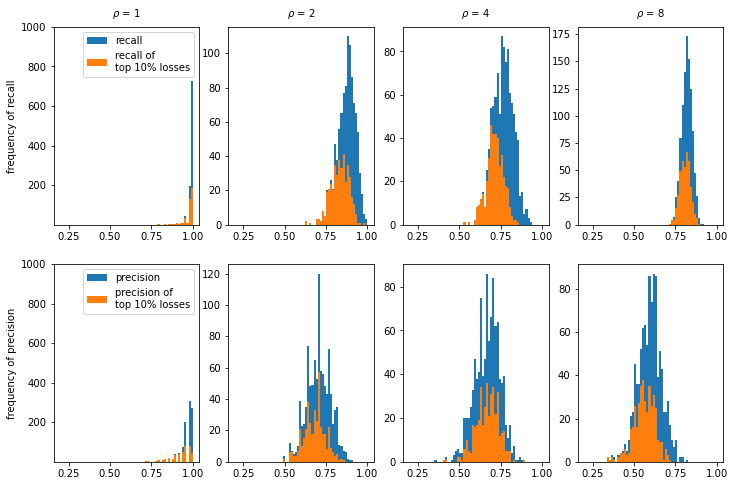

In [4]:
fig, axs = plt.subplots(nrows=2, ncols=4, figsize=(12, 8), sharey=False, sharex="row")
bins = np.histogram(np.linspace(0.2, 1, 32), bins = 64)[1]
for l, i, d in zip((d1, d2, d4, d8), range(4), [1,2,4,8]):
    threshold = 4096//10
    data = pd.DataFrame()
    data["prec"] = l[0]
    data["recall"] = l[1]
    data["SHD"] = l[2]
    data["losses"] = l[3]
    data.sort_values("losses", inplace = True, ascending = False)
    data.reset_index(inplace = True, drop = True)
    axs[0,i].hist(data["recall"], bins = bins, label = "recall")
    axs[0,i].hist(data["recall"][:threshold], bins = bins, label = "recall of\ntop 10"+r"% losses")
    axs[1,i].hist(data["prec"], bins = bins, label = "precision")
    axs[1,i].hist(data["prec"][:threshold], bins = bins, label = "precision of\ntop 10"+r"% losses")
    label = r"$\rho$ = " + str(d)
    axs[0,i].set_xlabel(label)
    axs[0,i].xaxis.set_label_coords(0.5, 1.10)
axs[0,0].set_ylabel("frequency of recall")
axs[1,0].set_ylabel("frequency of precision")
axs[0,0].legend()
axs[1,0].legend()
axs[0,0].set_ylim(1,1000)
axs[1,0].set_ylim(1,1000)
plt.savefig("plot", dpi = 500, transparent = "False")
